# 10339 - Catalysis: Homework \#1 Solutions
## CatApp, Adsorption Energies, and Potential Energy Diagrams

Consider the CO oxidation reaction:
$$2 \text{CO(g)}+\text{O}_2 (\text{g}) \rightleftharpoons 2 \text{CO}_2 (\text{g})$$

The overall mechanism can be written as a sequence of the following elementary reaction steps.

1. $$\text{CO(g) + *} \rightleftharpoons \text{CO*}$$
2. $$\text{O}_2\text{(g) + 2*} \rightleftharpoons 2\text{O*}$$
3. $$\text{CO* + O*} \rightleftharpoons \text{CO}_2\text{(g) + 2*}$$


## 1.

Use the online CatApp tool to tabulate the reaction energies and activation barriers for the (111) surfaces of the following metals: Ru, Rh, Pt, Pd, Cu, Au.

### Solution

Download database: 
[CatApp](https://cmr.fysik.dtu.dk/_downloads/716b1e0826acbb3d80675c116a2cb8a6/catapp.db)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from ase.db import connect
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import copy

# Connect to the CatApp database
catapp=connect('catapp.db')

def reaction(catapp,reverse=False,**kwargs):
    """Download reactions from CatApp. ab -> a + b if reverse=False
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            output : list
                Output is a list with the reaction, the surface, 
                energy of the reaction and the activation energy
    """
    output=[]
    for row in catapp.select(**kwargs):
        er=row.er
        ea=row.ea
        ea=np.max([0,er,ea])
        if reverse==True:
            er=-er
            ea+=er
            # The activation energy must be the largest
            ea=np.max([0,er,ea])
            react='{} + {} -> {}'.format(row.a,row.b,row.ab)
            surf=row.surface
        else:
            react='{} -> {} + {}'.format(row.ab,row.a,row.b)
            surf=row.surface
        output.append((react,surf,er,ea))
    return output
        
def reaction_dict(catapp,reverse=False,react_list=[],pd_react=None,**kwargs):
    """A wrapper that makes a dict of the data from CatApp
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            react_list : list of str
                A list of all the reactions (can be continued in a new function call)
            pd_react : dict
                A dictionary with the surfaces, energy differences and activation energies
                that can be continued in a new function call
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            pd_react : dict
                A dictionary with the surface, 
                energy of the reaction and the activation energy
            react_list : list
                A list of all the reactions
    """
    if pd_react is None:
        pd_react={'Surface':[],'E_diff':[],'Ea':[]}
    for r in reaction(catapp,reverse=reverse,**kwargs):
        react,surf,er,ea=list(r)
        pd_react['Surface'].append(surf)
        if react not in react_list:
            react_list.append(react)
        pd_react['E_diff'].append(er)
        pd_react['Ea'].append(ea)
    return pd_react,react_list
    
        
# Surfaces investigated
surfaces=['Ru(111)','Rh(111)','Pt(111)','Pd(111)','Cu(111)','Au(111)']
pd_list=[]
react_list=[]

# The CO+*->CO* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CO*','a':'CO', 'b':'*','surface':surf})

pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The O2+2*->2O* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=False,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'O2','surface':surf})

pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# The CO*+O*->CO2+2* elementary reaction
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
for surf in surfaces:
    pd_dict,react_list=reaction_dict(catapp,reverse=True,react_list=react_list,\
                                     pd_react=pd_dict,**{'ab':'CO2','b':'CO*', 'a':'O*','surface':surf})
    
pd_list.append(pd.DataFrame(pd_dict).set_index('Surface'))

# Merge the pandas dataframes
pd_list=pd.concat(pd_list,axis=1,keys=react_list)
display(pd_list)

# Hint: You will want to save these energies since you will be using them many timesin the course
pickle.dump(pd_list,open('HW1_ener_catapp.pkl','wb'))

CO + * -> CO*      O2 -> O* + O*       O* + CO* -> CO2      
               E_diff   Ea        E_diff    Ea          E_diff    Ea
Surface                                                             
Ru(111)         -1.64  0.0         -4.87  0.00            1.13  1.30
Rh(111)         -1.60  0.0         -3.63  0.00            0.47  1.21
Pt(111)         -1.24  0.0         -1.49  0.62           -0.96  0.72
Pd(111)         -1.39  0.0         -1.63  0.61           -0.74  1.10
Cu(111)         -0.36  0.0         -2.59  0.01           -1.29  0.53
Au(111)          0.10  0.1          0.49  2.49           -3.29  0.09

## 2)

The energies from CatApp are reaction energies/barriers which are always relative to the initial state. It is sometimes useful to instead use “adsorption” or “binding” energies relative to a common reference state.  


Calculate the energies of CO(g), O$_2$(g), CO$_2$(g), CO*, O*, O-O$_{TS}$*, and O-CO$_{TS}$* on Pt(111) relative to the following references: 

\begin{align}
\text{(A)} \quad &\text{C}_{ref}=\text{CO}, \quad &\text{O}_{ref}=\text{O}_2 \notag \\
\text{(B)} \quad &\text{C}_{ref}=\text{CO}_2, \quad &\text{O}_{ref}=\text{O}_2 \notag \\
\text{(C)} \quad &\text{C}_{ref}=\text{C}_{graphite}, \quad &\text{O}_{ref}=\text{O}_2 \notag \\
\text{(D)} \quad &\text{C}_{ref}=\text{CH}_4, \quad &\text{O}_{ref}=\text{H}_2O \notag
\end{align}

You will need to use the following reaction energies: 
\begin{align}
4. \quad & 2\text{CO}(g) + \text{O}_2(g) &\rightleftharpoons& 2\text{CO}_2(g) \quad &\Delta E_{rxn}=-5.82 \text{eV} \notag \\
5. \quad & 2\text{CO}(g) &\rightleftharpoons& 2\text{C}_{graphite} + \text{O}_2(g) \quad &\Delta E_{rxn}=2.21 \text{eV} \notag \\
6. \quad & \text{CO}(g) + 3\text{H}_2(g) &\rightleftharpoons& \text{CH}_{4}(g) + \text{H}_2\text{O}(g) \quad &\Delta E_{rxn}=-2.77 \text{eV} \notag \\
7. \quad & 2\text{H}_2(g) + \text{O}_2(g) &\rightleftharpoons& 2\text{H}_{2}O(g) \quad &\Delta E_{rxn}=-5.43 \text{eV} \notag
\end{align}

Assume that H$_2(g)$ is also a reference state ($E_{H_2(g)} = 0$), and ensure that the transition-state energy is always greater than or equal to the energy of the initial and final states. 

Note that O-CO$_{TS}$* and O-CO* is the same!


### Solution

Note that the total reaction energy from CatApp sums up to $\Delta E_{rxn}=-5.89$ eV for all surfaces. Therefore, either $\Delta E_{rxn}=-5.89$ eV or $\Delta E_{rxn}=-5.82$ eV from equation 4 can be used and both are correct.


$E_{CO_2}$ and the energy of all adsorbed species can be expressed as some combination of reaction energies from Problem 1, $E_{CO(g)}$, and $E_{O_2(g)}$. For each reference, we just have to figure out what those energies are, and use the same machinery to fll out the table for each reference. 

"(g)" and "eV" will be implied from here onwards.


Reference (A):
    \begin{eqnarray}
        E_{CO} =& \bf{0} \notag \\ 
        E_{O_2} =& \bf{0} \notag \\
        2E_{CO_2} - 2E_{CO} - E_{O_2} =& -5.82 \notag \\
        E_{CO_2} = \frac{1}{2}* (-5.82+2E_{CO}+E_{O_2}) = \frac{1}{2}* (-5.82+2*0+0) =& \bf{-2.91} \notag \\
        E_{CO*} = E_{CO} + \Delta E_1  = 0 + -1.2 =& \bf{-1.2} \notag  \\
        E_{O*} = \frac{1}{2}(E_{O_2} + E_2) = \frac{1}{2}(0 + -1.5) =& \bf{-0.75} \notag \\
        E_{O-O*} = E_{O_2} + E_{2,a} = 0 + 0.62 =& \bf{0.62} \notag \\
        E_{O-CO*} = E_{O*} + E_{CO*} + E_{3,a} = -0.75 + -1.2 + 0.72 =& \bf{-1.23}  \notag
    \end{eqnarray}
    For references (B), (C), and (D), we can use the equattions the same way if can find what $E_{CO}$ and $E_{O_2}$ are in the new reference.  
    
Reference (B):
    \begin{eqnarray}
        E_{CO_2} =& \bf{0} \notag \\ 
        E_{O_2} =& \bf{0} \notag \\
        2E_{CO_2} - 2E_{CO} - E_{O_2} =& -5.82 \notag \\
        E_{CO} = \frac{1}{2}* (5.82+2E_{CO_2}-E_{O_2}) = \frac{1}{2}* (5.82+2*0+0) =& \bf{2.91} \notag
    \end{eqnarray}
    
Reference (C):
    \begin{eqnarray}
        E_{C} =& 0 \nonumber \\ 
        E_{O_2} =& \bf{0} \nonumber \\
        2E_C + E_{O_2} - 2E_{CO} =& 2.21 \nonumber \\
        E_{CO} = \frac{1}{2}* (-2.21+2E_{C}+E_{O_2}) = \frac{1}{2}* (-2.21+2*0+0) =& \bf{-1.105} \nonumber 
    \end{eqnarray}
    
Reference (D):
    \begin{eqnarray}
        E_{CH_4} =& 0 \nonumber \\ 
        E_{H_2O} =& 0 \nonumber \\
        E_{H_2} = & 0 \nonumber \\
        2E_{H_2O} - 2E_{H_2} -E_{O_2} =& -5.43 \nonumber \\
        E_{O_2} = 2E_{H_2O} - 2E_{H_2} + 5.43 = 2*0 - 2*0 + 5.43 =& \bf{5.43} \nonumber \\
        E_{CH_4} + E_{H_2O} - E_{CO} - 3E_{H_2} =& -2.77 \nonumber \\
        E_{CO} = E_{CH_4} + E_{H_2O} - 3E_{H_2} + 2.77 = 0 + 0 -3*0 + 2.77 =& \bf{2.77} \nonumber
    \end{eqnarray}
    We can reconstruct the reaction energies in Problem 1 with any of the references.  Here, I show an example of 
    rebuilding $\Delta E_3$ and $\Delta E_{3,a}$ from each of the four references: 
    

Reference (A):
    \begin{eqnarray}
        E_{3} = E_{CO_2} - E_{CO*} - E_{O*} = -2.91 - (-1.2) - (-0.75) =& \bf{-0.96} \nonumber \\ 
        E_{3,a} = E_{O-CO*} - E_{CO*} - E_{O*} =  -1.23 - (-1.2) - (-0.75) =& \bf{0.71} \nonumber 
    \end{eqnarray}
    
Reference (B):
    \begin{eqnarray}
        E_{3} = E_{CO_2} - E_{CO*} - E_{O*} = 0.0 - 1.71 - (-0.75) =& \bf{-0.96} \nonumber \\ 
        E_{3,a} = E_{O-CO*} - E_{CO*} - E_{O*} =  1.68 - 1.71 - (-0.75) =& \bf{0.71} \nonumber 
    \end{eqnarray}
    
Reference (C):
    \begin{eqnarray}
        E_{3} = E_{CO_2} - E_{CO*} - E_{O*} = -4.015 - (-2.305) - (-0.75) =& \bf{-0.96} \nonumber \\ 
        E_{3,a} = E_{O-CO*} - E_{CO*} - E_{O*} =  -2.335 - (-2.305) - (-0.75) =& \bf{0.71} \nonumber 
    \end{eqnarray}
    
Reference (D):
    \begin{eqnarray}
        E_{3} = E_{CO_2} - E_{CO*} - E_{O*} = 2.575 - 1.57 - 1.965 =& \bf{-0.96} \nonumber \\ 
        E_{3,a} = E_{O-CO*} - E_{CO*} - E_{O*} =  4.255 - 1.57 - 1.965 =& \bf{0.71} \nonumber 
    \end{eqnarray}

In [2]:
# All compounds that the energy is obtained for
compounds=['CO','O2','CO2','[CO*]TS','CO*','O*','O-O*','O-CO*']

# Reactants and products for all elementary reactions including TS formation
products=[['CO*'],['[CO*]TS'],['O*','O*'],['O-O*'],['CO2'],['O-CO*']]
reactants=[['CO'],['CO'],['O2'],['O2'],['CO*','O*'],['CO*','O*']]

# Load results from problem 1.
pd_surf=pickle.load(open('HW1_ener_catapp.pkl','rb'))

# Get only the energies from Pt(111)
i=np.where('Pt(111)'==pd_surf.index)[0][0]
energies=[]
for key in pd_surf.keys():
    energies.append(pd_surf[key][i])
#energies=[-1.2,0.0,-1.5,0.62,-0.96,0.72]
print('Reaction energies for Pt(111):',energies)

def comp_energies(compounds,reactants,products,energies,ref,ref_txt):
    'Compare energies by multiple references'
    react=reactants+ref['Reactants']
    prod=products+ref['Products']
    ener=energies+ref['Energies']
    coef_matrix=np.zeros((len(prod),len(compounds)))
    for row in range(len(coef_matrix)):
        for col in range(len(coef_matrix[0])):
            if compounds[col] in prod[row]:
                coef_matrix[row,col]+=prod[row].count(compounds[col])
            if compounds[col] in react[row]:
                coef_matrix[row,col]-=react[row].count(compounds[col])
    comp_energy=np.linalg.solve(coef_matrix,ener)
    pd_dict={'Ref':ref_txt}
    for e in range(len(compounds)):
        pd_dict[compounds[e]]=[round(comp_energy[e],2)]
    return pd.DataFrame(pd_dict)

pd_list=[]

# Reference A
ref={'Reactants':[[],[]],'Products':[['CO'],['O2']],'Energies':[0,0]}
pd_list.append(comp_energies(compounds,reactants,products,energies,ref,'CO=0 eV & O2=0 eV'))

# Reference B
ref={'Reactants':[[],[]],'Products':[['CO2'],['O2']],'Energies':[0,0]}
pd_list.append(comp_energies(compounds,reactants,products,energies,ref,'CO2=0 eV & O2=0 eV'))

# Reference C
ref={'Reactants':[['CO','CO'],[]],'Products':[['O2'],['O2']],'Energies':[2.21,0]}
pd_list.append(comp_energies(compounds,reactants,products,energies,ref,'C=0 eV & O2=0 eV'))

# Reference D
ref={'Reactants':[['CO'],['O2']],'Products':[[],[]],'Energies':[-2.77,-5.43]}
pd_list.append(comp_energies(compounds,reactants,products,energies,ref,'CH4=0 eV & H2O=0 eV'))

# Show the results in a table
pd_list=pd.concat(pd_list,ignore_index=True)
pd_list=pd_list.drop('[CO*]TS',1)
display(pd_list)
# Save the data 
pd_list.to_csv('HW1_ref.csv')

Reaction energies for Pt(111): [-1.24, 0.0, -1.49, 0.62, -0.96, 0.72]


,Ref,CO,O2,CO2,CO*,O*,O-O*,O-CO*
0,CO=0 eV & O2=0 eV,-0.00,-0.00,-2.94,-1.24,-0.74,0.62,-1.27
1,CO2=0 eV & O2=0 eV,2.94,-0.00,0.00,1.70,-0.74,0.62,1.68
2,C=0 eV & O2=0 eV,-1.10,0.00,-4.05,-2.34,-0.74,0.62,-2.37
3,CH4=0 eV & H2O=0 eV,2.77,5.43,2.54,1.53,1.97,6.05,4.22


The Python solution is obtained by solving a linear matrix equation. 

Reference A, $E_{CO}=0$ eV and $E_{O_2}=0$ eV, is used as an example:

The energy equations can be written as:
\begin{align}
E_{CO*}-E_{CO} =& \Delta E_{1} \notag \\
2 E_{O*}-E_{O_2} =& \Delta E_{2} \notag \\
E_{O-O*}-E_{O_2} =& \Delta E_{2,a} \notag \\
E_{CO2}-E{CO*}-E_{O*} =& \Delta E_{3} \notag \\
E_{O-CO*}-E{CO*}-E_{O*} =& \Delta E_{3,a} \notag \\
E_{CO} =& 0 \notag \\
E_{O_2} =& 0 \notag
\end{align}

The energy equations can be written in a matrix representation:
\begin{align}
\textbf{A}\vec{x}=&\vec{y} \notag \\
\begin{bmatrix}
    -1 & 0 & 0 & 1 & 0 & 0 & 0 \\
    0 & -1 & 0 & 0 & 2 & 0 & 0 \\
    0 & -1 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 1 & -1 & -1 & 0 & 0 \\
    0 & 0 & 0 & -1 & -1 & 0 & 1 \\
    1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
    E_{CO} \\
    E_{O_2} \\
    E_{CO_2} \\
    E_{CO*} \\
    E_{O*} \\
    E_{O-O*} \\
    E_{O-CO*}
\end{bmatrix} =&
\begin{bmatrix}
    \Delta E_{1} \\
    \Delta E_{1,a} \\
    \Delta E_{2} \\
    \Delta E_{3} \\
    \Delta E_{3,a} \\
    0 \\
    0
\end{bmatrix}
\notag
\end{align}

Thereby, the energy for each compund can be found by inverting the coefficient matrix:
$$\vec{x}=\textbf{A}^{-1}\vec{y}$$


## 3)
Use the energetics from the previous problems to create a “potential energy diagram” of CO oxidation on each of the (111) surfaces.

*Hint: The overall reaction energy should be independent of catalyst surface to within 0.1 eV, but may vary slightly from the reaction energy given in 2. due to DFT error.*

### Solution

,Reactions,Ru(111),Rh(111),Pt(111),Pd(111),Cu(111),Au(111)
0,CO + * -> CO*,-1.64,-1.60,-1.24,-1.39,-0.36,0.10
1,[CO + * -> CO*]TS,0.00,0.00,0.00,0.00,0.00,0.10
2,CO + * -> CO*,-1.64,-1.60,-1.24,-1.39,-0.36,0.10
3,[CO + * -> CO*]TS,0.00,0.00,0.00,0.00,0.00,0.10
4,O2 + 2* -> 2 O*,-4.87,-3.63,-1.49,-1.63,-2.59,0.49
5,[O2 + 2* -> 2O-O*]TS,0.00,0.00,0.62,0.61,0.01,2.49
6,CO* + O* -> CO2 + 2*,1.13,0.47,-0.96,-0.74,-1.29,-3.29
7,[CO* + O* -> O-CO* + *]TS,1.30,1.21,0.72,1.10,0.53,0.09
8,CO* + O* -> CO2 + 2*,1.13,0.47,-0.96,-0.74,-1.29,-3.29
9,[CO* + O* -> O-CO* + *]TS,1.30,1.21,0.72,1.10,0.53,0.09


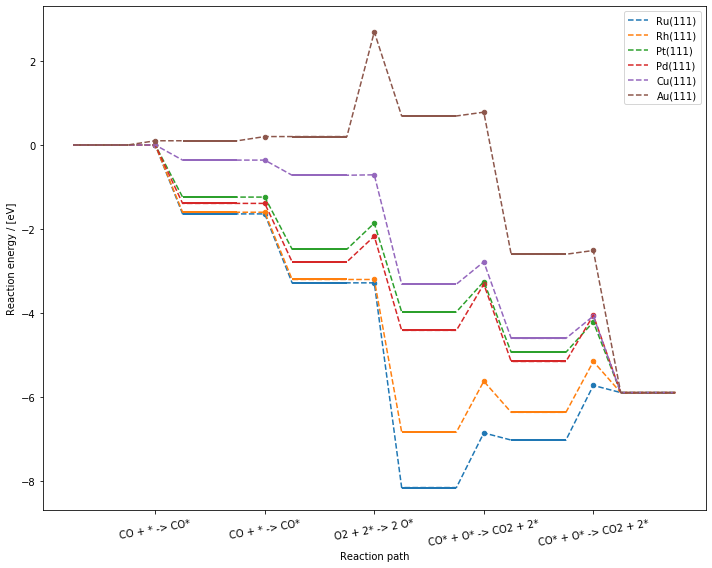

In [3]:
# initial energy
start=0

# Load the energies from Problem 1.
pd_surf=pickle.load(open('HW1_ener_catapp.pkl','rb'))
surfaces=np.copy(pd_surf.index)

# The reactions that will be plotted. Every second is the TS!!!
input_df={'Reactions':['CO + * -> CO*','[CO + * -> CO*]TS',
                       'CO + * -> CO*','[CO + * -> CO*]TS',
                       'O2 + 2* -> 2 O*','[O2 + 2* -> 2O-O*]TS',
                       'CO* + O* -> CO2 + 2*','[CO* + O* -> O-CO* + *]TS',
                       'CO* + O* -> CO2 + 2*','[CO* + O* -> O-CO* + *]TS']}

# Get the reaction energies for each surface
for s,surf in enumerate(surfaces):
    input_df[surf]=[]
    surf_keys=pd_surf.keys()
    k=0
    for r,react in enumerate(input_df['Reactions']):
        if input_df['Reactions'][r] in input_df['Reactions'][:r]:
            i=np.where(input_df['Reactions'][r]==np.array(input_df['Reactions'][:r]))[0][0]
            input_df[surf].append(input_df[surf][i])
        else:
            input_df[surf].append(pd_surf[surf_keys[k]][s])
            k+=1

# Show the energies for each surface (Same results as Problem 1.)
input_df=pd.DataFrame(input_df)
display(input_df)
# Save the energies
pickle.dump(input_df,open('HW1_energies.pkl','wb'))


def energy_diagram_data(DE,Ea,start):
    'Convert the data so it can be used for the energy diagram'
    energy=start
    x=[]
    E=[]
    x_without=[]
    E_without=[]
    for i in range(len(DE)):
        x.extend([2*i,2*i+1])
        x_without.extend([2*i,2*i+1])
        E.extend([energy,energy])
        E_without.extend([energy])
        xin=2*i+1.5
        Ein=Ea[i]+energy
        x.append(xin)
        E.append(Ein)
        energy+=DE[i]
    x.extend([2*i+2,2*i+3])
    x_without.extend([2*i+2,2*i+3])
    E.extend([energy,energy])
    E_without.extend([energy])
    return x,E,x_without,E_without

def energy_diagram_plot(input_df,start=0,ylabel='Reaction energy',rotation=10):
    'Plot the energy diagram from the input data'
    plt.figure(figsize=(10,8))
    for key in input_df:
        if key=='Reactions':
            xticks=[2*i+1.5 for i in range(len(input_df[key][::2]))]
            plt.xticks(xticks,input_df[key][::2],rotation=rotation)
        else:
            DE=input_df[key][::2].tolist()
            Ea=input_df[key][1::2].tolist()
            x,E,x_without,E_without=energy_diagram_data(DE,Ea,start)
            p=plt.plot(x,E,label=key,linestyle='--')
            color=p[0].get_color()
            plt.scatter(x[2::3],E[2::3],color=color,s=20)
            plt.hlines(E_without,x_without[::2],x_without[1::2],color=color,linewidth=2)
    plt.xlabel('Reaction path')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.tight_layout()
    plt.show()
    pass
    
    
energy_diagram_plot(input_df,start=start,ylabel='Reaction energy / [eV]') 
